In [19]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

Config

In [2]:
data_dir = '/Users/rebekahzhang/data/behavior_data'
exp = "exp2"
data_folder = os.path.join(data_dir, exp)
DATA_PATH = os.path.join(data_folder, "trials_training_filtered2.csv")
FIGURE_PATH = os.path.join(data_dir, f'{exp}_modeling_figures')
os.makedirs(FIGURE_PATH, exist_ok=True)

TARGET = "time_waited"
FEATURES = [
    "group", "mouse", "bg_length", "previous_trial_reward_outcome", "num_bg_licks",
    "time_since_last_reward", "session", "session_trial_num", "block_trial_num",
    "running_reward_rate", "cumulative_reward", "bg_drawn", "block_num"
]
CATEGORICAL = ["group", "previous_trial_reward_outcome", "mouse"]
NUMERIC = [col for col in FEATURES if col not in CATEGORICAL]

# Random state
RNG = 42

custom_palette = {'s': "#ffb400", 'l': "#9080ff"}

In [3]:
# Load and preprocess data
df = pd.read_csv(DATA_PATH)
df = df.loc[(df['miss_trial'] == False) & (~df[TARGET].isna())].copy()
df["time_since_last_reward"] = df["time_since_last_reward"].fillna(2000)
df["running_reward_rate"] = df["running_reward_rate"].fillna(0)

In [5]:
def compute_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return dict(r2=r2, mae=mae, rmse=rmse)

### baseline model using only grup

In [8]:
FEATURES_single = ["group"]
CATEGORICAL_single = ["group"]
NUMERIC_single = [c for c in FEATURES_single if c not in CATEGORICAL_single]

df_encoded = pd.get_dummies(df, columns=CATEGORICAL_single)

X = df_encoded[["group_l", "group_s"]]
y = df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RNG)

model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Mean predicted value for group_l: {y_pred[X_test['group_l'] == 1].mean():.3f}")
print(f"Mean predicted value for group_s: {y_pred[X_test['group_s'] == 1].mean():.3f}")

compute_metrics(y_test, y_pred)

Mean predicted value for group_l: 3.399
Mean predicted value for group_s: 2.114


{'r2': 0.018663049152502054,
 'mae': 2.3921631932413243,
 'rmse': 4.796866533134799}

### Models using to use all features

In [10]:
df['session_original'] = df['session']
df['session_trial_num_original'] = df['session_trial_num']
df['mouse_original'] = df['mouse']
df['group_original'] = df['group']

# One-hot encode categorical features and normalize numeric features
df_dummies = pd.get_dummies(df, columns=CATEGORICAL)
df_dummies[NUMERIC] = StandardScaler().fit_transform(df_dummies[NUMERIC])  

# Select all features: numeric + new dummies
dummy_features = [c for c in df_dummies.columns if c not in df.columns]
all_features = NUMERIC + dummy_features

X = df_dummies
y = df[TARGET]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RNG
)
X_train, X_test = X_train_raw[all_features], X_test_raw[all_features]

linear regression

In [11]:
# Fit and predict
model_linear = LinearRegression().fit(X_train, y_train)
y_pred_linear = model_linear.predict(X_test)

# Group means
print(f"Mean predicted value for group_l: {y_pred_linear[X_test['group_l'] == 1].mean():.3f}")
print(f"Mean predicted value for group_s: {y_pred_linear[X_test['group_s'] == 1].mean():.3f}")

# Metrics
metrics = compute_metrics(y_test, y_pred_linear)
metrics

Mean predicted value for group_l: 3.394
Mean predicted value for group_s: 2.097


{'r2': 0.13822340502410646,
 'mae': 2.2223557087366914,
 'rmse': 4.495167782283447}

random forest

In [12]:
# Fit model and predict
model_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=100,
    n_jobs=-1,
    random_state=RNG
)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

# Group means
print(f"Mean predicted value for group_l: {y_pred_rf[X_test['group_l'] == 1].mean():.3f}")
print(f"Mean predicted value for group_s: {y_pred_rf[X_test['group_s'] == 1].mean():.3f}")

# Metrics
metrics = compute_metrics(y_test, y_pred_rf)
metrics

Mean predicted value for group_l: 3.515
Mean predicted value for group_s: 2.159


{'r2': 0.35133706163753764,
 'mae': 1.8216608683189264,
 'rmse': 3.8999415802728508}

### random forest plots

In [13]:
predictions = model_rf.predict(X_test)
X_test_raw["predictions"] = predictions

df_to_plot = X_test_raw

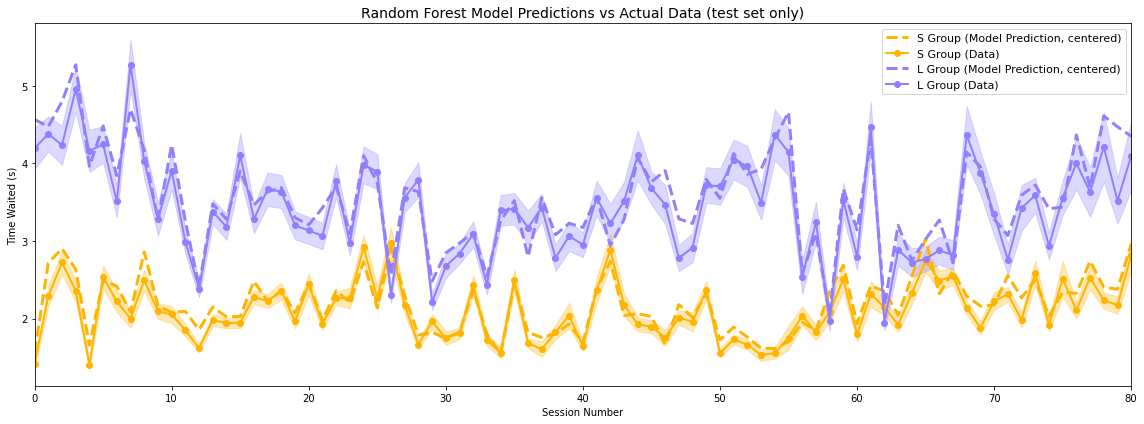

In [14]:
# Aggregate session-level stats for actual and predicted values
session_stats = (
    df_to_plot.groupby(['session_original', 'group_original'], as_index=False)
    .agg(
        mean_tw=('time_waited', 'mean'),
        se_tw=('time_waited', lambda x: x.std() / np.sqrt(max(len(x), 1))),
        mean_pred=('predictions', 'mean')
    )
)

plt.figure(figsize=(16, 6))
for group in df['group_original'].unique():
    group_stats = session_stats[session_stats['group_original'] == group]
    # Plot model predictions (dashed)
    plt.plot(
        group_stats['session_original'],
        group_stats['mean_pred'],
        '--', linewidth=3, color=custom_palette[group],
        label=f'{group.upper()} Group (Model Prediction, centered)'
    )
    # Plot actual data (solid)
    plt.plot(
        group_stats['session_original'],
        group_stats['mean_tw'],
        'o-', markersize=6, linewidth=2, color=custom_palette[group],
        label=f'{group.upper()} Group (Data)'
    )
    # Error band for actual data
    plt.fill_between(
        group_stats['session_original'],
        group_stats['mean_tw'] - group_stats['se_tw'],
        group_stats['mean_tw'] + group_stats['se_tw'],
        alpha=0.3, color=custom_palette[group]
    )

plt.title('Random Forest Model Predictions vs Actual Data (test set only)', fontsize=14)
plt.xlabel('Session Number')
plt.ylabel('Time Waited (s)')
plt.legend(fontsize=11)
plt.xlim(df['session_original'].min(), df['session_original'].max())
plt.tight_layout()
plt.savefig(f'{FIGURE_PATH}/rf_predictions_vs_actual.png', dpi=300, bbox_inches='tight')

In [17]:
def plot_session_fit(df, session_info, fig_size=(12, 5), save_path=None):
    # Filter for the session
    session_data = df[df['dir'] == session_info['dir']].sort_values('session_trial_num_original')
    group = session_info['group_original']
    trial_nums = session_data['session_trial_num_original']
    actual = session_data['time_waited']
    pred = session_data['predictions']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
    # Actual vs Predicted
    ax1.plot(trial_nums, actual, 'o', color=custom_palette[group], label='Actual', markersize=4, alpha=0.7)
    ax1.plot(trial_nums, pred, 's', color='b', label='Predicted', markersize=3, alpha=0.7)
    ax1.set(xlabel='Trial Number', ylabel='Time Waited (s)', title='Actual vs Predicted')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Residuals
    residuals = actual - pred
    ax2.scatter(trial_nums, residuals, color=custom_palette[group], alpha=0.7, s=20)
    ax2.axhline(0, color='black', linestyle='--', alpha=0.8)
    ax2.set(xlabel='Trial Number', ylabel='Residuals', title='Prediction Residuals')
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return fig

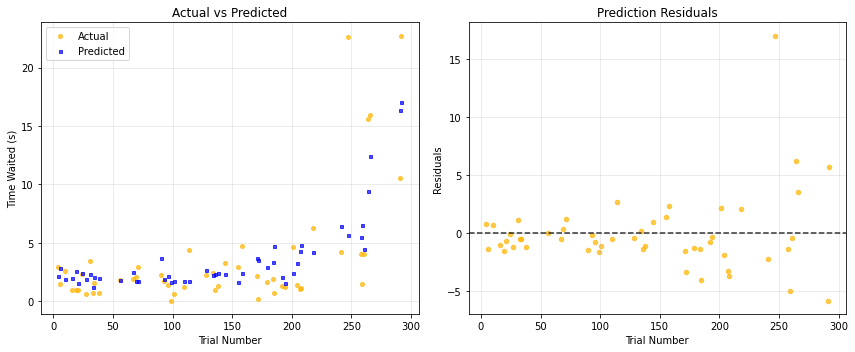

In [18]:
fig = plot_session_fit(df_to_plot, df_to_plot.iloc[0], save_path=f'{FIGURE_PATH}/session_fit_comparison.png')

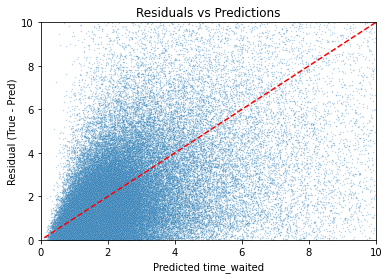

In [28]:
# residual plots
actual = df_to_plot['time_waited']
pred = df_to_plot['predictions']
residuals = actual - pred

plt.figure(figsize=(6,4))
sns.scatterplot(x=pred, y=actual, alpha=0.3, s=2)
plt.plot([pred.min(), pred.max()], [pred.min(), pred.max()], color="red", linestyle="--")
plt.xlabel("Predicted time_waited")
plt.ylabel("Residual (True - Pred)")
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.title("Residuals vs Predictions")
plt.show()

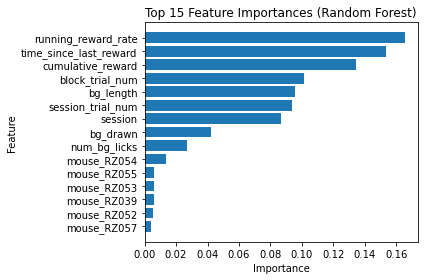

In [ ]:
importances = model_rf.feature_importances_
feat_names = X_train.columns
fi = pd.Series(importances, index=feat_names).sort_values(ascending=False)[:15]

plt.figure(figsize=(6,4))
plt.barh(range(len(fi)), fi.values)
plt.yticks(range(len(fi)), fi.index)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()